<a href="https://colab.research.google.com/github/ngyxntthaoo/IS6404.CH201-Phan-tich-du-lieu-nang-cao/blob/main/Lab_4_Traditional_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Tổng quan các kỹ thuật phân tích dữ liệu cổ điển
**Course:** IS6404 - Advanced Data Analysis, UIT, VNUHCM  
**Lecturer:** Dr. Tran Hung Nghiep, 2026  

---

Mục tiêu của buổi này không phải học sâu công thức, mà là:
- Biết **khi nào dùng** các kỹ thuật cổ điển (regression, hypothesis testing, optimization)
- Biết dùng chúng như **baseline** và **công cụ kiểm chứng** trong pipeline ML/AI
- Hiểu các **hạn chế** (assumptions, leakage, p-hacking, overfitting, constraint mismatch)

> Notebook này có 3 phần chính: **Hồi quy**, **Kiểm chứng giả thuyết**, **Tối ưu**.  
> Mỗi phần đều có câu hỏi để người học trả lời.

## 0. Setup & Reproducibility
Cố định seed, in versions, tạo thư mục outputs.

In [1]:
# 0) Setup
import json, os, sys, platform
from datetime import datetime

import numpy as np
import pandas as pd
import sklearn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("python:", sys.version)
print("platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1


## 1. Dataset (dữ liệu mẫu cho regression + hypothesis testing)

Ta dùng dataset `diabetes` từ scikit-learn (có sẵn, chạy nhanh).
- Target: tiến triển bệnh (một đại lượng liên tục) -> phù hợp regression
- Có feature `sex` (đã chuẩn hóa) -> tạo điều kiện làm kiểm chứng giả thuyết giữa 2 nhóm

> Trong đồ án thật, hãy giữ cấu trúc notebook và thay bằng dataset của nhóm.


In [2]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
df = data.frame.copy()
df.rename(columns={"target": "y"}, inplace=True)

df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
print("shape:", df.shape)
df.describe().T.head(12)


shape: (442, 11)


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


## 2. Hồi quy tuyến tính (Linear Regression) như baseline + interpretability

### Vai trò trong pipeline ML/AI
- Baseline mạnh, dễ giải thích
- Kiểm tra nhanh mối quan hệ tuyến tính và multicollinearity
- Tạo feature/insight trước khi dùng model phức tạp

### Cảnh báo
- Assumptions (tuyến tính, độc lập, phương sai đồng nhất, sai số gần chuẩn) thường **không hoàn hảo**
- Không suy ra nhân quả chỉ từ hồi quy

### **Câu hỏi**
1) Với dữ liệu của nhóm bạn, hồi quy tuyến tính có thể là baseline không? Vì sao?
2) Nếu feature có quan hệ phi tuyến, dấu hiệu nào cho thấy OLS không phù hợp?


### 2.1 Train/Test split (để tránh đánh giá ảo)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_train.shape, X_test.shape


((353, 10), (89, 10))

### 2.2 Linear regression bằng scikit-learn

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

{"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


{'test_MAE': 42.79409467959994,
 'test_RMSE': np.float64(53.85344583676592),
 'test_R2': 0.4526027629719197}

### 2.3 Hồi quy OLS bằng statsmodels để xem hệ số và p-values

In [7]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)  # thêm intercept
ols = sm.OLS(y_train, X_train_sm).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Sat, 31 Jan 2026   Prob (F-statistic):           5.41e-50
Time:                        09:28:39   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.3456      2.902     52.155      0.000     145.638     157.053
age           37.9040     69.056      0.549      0.583     -97.923     173.731
sex         -241.9644     68.570     -3.529      0.000    -376.836    -107.093
bmi          542.4288     76.956      7.049      0.000     391.062     693.795
bp           347.7038     71.357      4.873      0.000     207.350     488.057
s1          -931.4888    451.138     -2.065      0.040   -1818.844     -44.134
s2           518.0623    364.114      1.423      0.156    -198.122    1234.247
s3           163.4200    233.014      0.701      0.484    -294.901     621.741
s4           275.3179    185.400      1.485      0.138     -89.349     639.985
s5           736.1989    192.437      3.826      0.000     357.689    1114.709
s6            48.6707     73.435      0.663      0.508     -95.771     193.113
==============================================================================
Omnibus:                        1.457   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.412
Skew:                           0.064   Prob(JB):                        0.494
Kurtosis:                       2.718   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Gợi ý đọc kết quả OLS (đơn giản):**
- `coef`: hướng và độ mạnh ảnh hưởng (theo mô hình tuyến tính)
- `P>|t|`: p-value của giả thuyết hệ số = 0 (cẩn thận diễn giải)
- `R-squared`: mức giải thích biến thiên (không phải thước đo duy nhất)

> Trong ML hiện đại, p-value không phải lúc nào cũng là trọng tâm, nhưng nó hữu ích để **kiểm tra nhanh** và **diễn giải**.


### 2.4 Chẩn đoán nhanh: residuals (dấu hiệu phi tuyến / outliers)

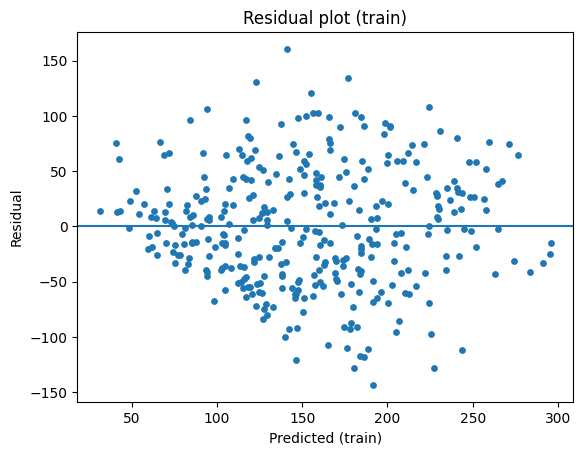

In [8]:
import matplotlib.pyplot as plt

pred_train = ols.predict(sm.add_constant(X_train))
resid = y_train - pred_train

plt.figure()
plt.scatter(pred_train, resid, s=15)
plt.axhline(0)
plt.xlabel("Predicted (train)")
plt.ylabel("Residual")
plt.title("Residual plot (train)")
plt.show()


## 3. Hồi quy phi tuyến (Non-linear regression) dưới dạng feature engineering

Thay vì đi sâu các mô hình phi tuyến cổ điển, ta dùng cách thực dụng:
- **Polynomial features + regularization** để bắt quan hệ phi tuyến
- So sánh với OLS baseline

### Vai trò trong pipeline
- Tạo baseline phi tuyến đơn giản trước khi dùng tree/NN
- Cho thấy lợi ích của feature engineering

### **Câu hỏi**
1) Polynomial degree tăng sẽ gây rủi ro gì?
2) Vì sao regularization (Ridge/Lasso) thường cần khi thêm polynomial features?


In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

poly_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", Ridge(random_state=RANDOM_SEED))
])

param_grid = {
    "poly__degree": [1, 2, 3],
    "model__alpha": [0.1, 1.0, 10.0, 100.0],
}

gs = GridSearchCV(poly_ridge, param_grid, cv=5, scoring="neg_mean_absolute_error")
gs.fit(X_train, y_train)

best = gs.best_estimator_
pred = best.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

gs.best_params_, {"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


({'model__alpha': 10.0, 'poly__degree': 1},
 {'test_MAE': 42.85682524780061,
  'test_RMSE': np.float64(53.62628756889519),
  'test_R2': 0.4572109567780849})

## Minh hoạ assumption violation gây sai lệch

- heteroscedasticity
- multicollinearity
- overfitting khi degree tăng

In [10]:
from sklearn.metrics import mean_absolute_error

for deg in [1,2,3,5,8]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("lr", LinearRegression())
    ])
    model.fit(X_train, y_train)
    print("degree", deg, "MAE", mean_absolute_error(y_test, model.predict(X_test)))


degree 1 MAE 42.794094679599944
degree 2 MAE 43.58169325465275
degree 3 MAE 164.8538972836308
degree 5 MAE 226.571280075446
degree 8 MAE 957.360809195518


## 4. Kiểm chứng giả thuyết (Hypothesis Testing) để kiểm tra claim

### Vai trò trong pipeline ML/AI
- Kiểm tra khác biệt giữa nhóm (A/B, cohort, segment)
- Kiểm tra feature có liên hệ đáng kể với target không
- Hỗ trợ data understanding và error analysis

### Giới hạn và rủi ro
- p-value không đo “mức độ quan trọng thực tế” (cần effect size, CI)
- Nhiều phép thử -> tăng false positives (p-hacking)
- Giả định phân phối có thể không đúng -> cân nhắc permutation/bootstrapping

### **Câu hỏi**
1) p-value nhỏ nghĩa là gì? p-value không có nghĩa là gì?
2) Vì sao cần effect size/CI bên cạnh p-value?


### 4.1 Tạo 2 nhóm theo feature `sex`
Trong dataset này, `sex` đã chuẩn hóa quanh 0. Ta tách nhóm theo dấu.

In [11]:
df2 = df.copy()
df2["sex_group"] = np.where(df2["sex"] >= 0, "group_A", "group_B")

df2["sex_group"].value_counts(), df2.groupby("sex_group")["y"].mean()


(sex_group
 group_B    235
 group_A    207
 Name: count, dtype: int64,
 sex_group
 group_A    155.666667
 group_B    149.021277
 Name: y, dtype: float64)

### 4.2 Two-sample t-test (so sánh trung bình y giữa 2 nhóm)

In [12]:
from scipy import stats

a = df2.loc[df2["sex_group"] == "group_A", "y"].values
b = df2.loc[df2["sex_group"] == "group_B", "y"].values

t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)  # Welch's t-test
t_stat, p_val


(np.float64(0.9022224453390377), np.float64(0.3674449793083975))

### 4.3 Effect size (Cohen's d) + confidence interval (bootstrap)

In [13]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(pooled)

d = cohens_d(a, b)
d


np.float64(0.08618180539347013)

In [14]:
# Bootstrap CI for mean difference
def bootstrap_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.mean(xb) - np.mean(yb))
    return np.percentile(diffs, [2.5, 50, 97.5])

ci = bootstrap_mean_diff(a, b)
ci  # [2.5%, 50%, 97.5%]


array([-6.95382876,  6.66865043, 20.90665433])

### 4.4 Permutation test (khi muốn giảm phụ thuộc vào giả định phân phối)

In [15]:
def permutation_test_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    obs = np.mean(x) - np.mean(y)
    pooled = np.concatenate([x, y]).copy()
    nx = len(x)
    diffs = []
    for _ in range(n):
        rng.shuffle(pooled)
        diffs.append(np.mean(pooled[:nx]) - np.mean(pooled[nx:]))
    diffs = np.array(diffs)
    p = (np.abs(diffs) >= abs(obs)).mean()
    return obs, p

obs, p_perm = permutation_test_mean_diff(a, b)
obs, p_perm


(np.float64(6.645390070921962), np.float64(0.3736))

## Minh hoạ về multiple testing và p-hacking

In [16]:
from scipy import stats

pvals = []
for col in X.columns:
    r, p = stats.pearsonr(X[col], y)
    pvals.append((col, p))

sorted(pvals, key=lambda x: x[1])[:50]


[('bmi', np.float64(3.4660064451669974e-42)),
 ('s5', np.float64(8.826458958879914e-39)),
 ('bp', np.float64(1.649372052742727e-22)),
 ('s4', np.float64(2.3042532817538887e-21)),
 ('s3', np.float64(6.162864695184841e-18)),
 ('s6', np.float64(7.580083266085433e-17)),
 ('s1', np.float64(6.92071178776012e-06)),
 ('age', np.float64(7.05568614911625e-05)),
 ('s2', np.float64(0.0002359848095985424)),
 ('sex', np.float64(0.3664292946519808))]

## 5. Tối ưu (Optimization) như một module trong hệ thống dữ liệu

### Vai trò trong pipeline ML/AI
- Sau khi dự báo/ước lượng (ML), ta cần **ra quyết định** (optimization)
- Ví dụ:
  - dự báo nhu cầu -> tối ưu tồn kho
  - dự báo churn -> tối ưu phân bổ ngân sách giữ chân
  - scoring khách hàng -> tối ưu chọn top-K theo ràng buộc

### Bài lab: 2 bài toán minh họa
A) Linear Programming: tối ưu product mix (tuyến tính, ràng buộc tuyến tính)  
B) Non-linear Optimization: tối ưu giá (có độ cong, không tuyến tính)

### **Câu hỏi**
1) Vì sao optimization thường đứng sau ML trong hệ thống thực?
2) Khi nào mô hình tối ưu tuyến tính không phù hợp?


### 5A. Linear Programming (LP): Product mix optimization
Bài toán: chọn sản lượng 3 sản phẩm để tối đa lợi nhuận, bị giới hạn bởi tài nguyên.

In [17]:
import numpy as np
from scipy.optimize import linprog

# Decision variables: x1, x2, x3 (sản lượng 3 sản phẩm)
profit = np.array([30, 20, 25])  # lợi nhuận / đơn vị

# Constraints (Ax <= b)
# Resource 1: 2x1 + 1x2 + 1x3 <= 100
# Resource 2: 1x1 + 3x2 + 2x3 <= 120
A = np.array([
    [2, 1, 1],
    [1, 3, 2]
])
b = np.array([100, 120])

bounds = [(0, None), (0, None), (0, None)]

res = linprog(c=-profit, A_ub=A, b_ub=b, bounds=bounds, method="highs")
res.success, res.message


(True, 'Optimization terminated successfully. (HiGHS Status 7: Optimal)')

In [18]:
x = res.x
max_profit = profit @ x
{"x1": x[0], "x2": x[1], "x3": x[2], "max_profit": max_profit}


{'x1': np.float64(26.66666666666667),
 'x2': np.float64(0.0),
 'x3': np.float64(46.666666666666664),
 'max_profit': np.float64(1966.6666666666665)}

### 5B. Non-linear optimization: Pricing
Giả sử nhu cầu giảm theo giá theo hàm mũ. Tối ưu giá để tối đa lợi nhuận.

In [19]:
from scipy.optimize import minimize

# Demand model: q(p) = a * exp(-b*p)
a, b = 1000, 0.05
unit_cost = 5.0  # chi phí đơn vị

def demand(p):
    return a * np.exp(-b * p)

def neg_profit(p_vec):
    p = p_vec.item()
    q = demand(p)
    profit = (p - unit_cost) * q
    return -profit

res2 = minimize(neg_profit, x0=np.array([30.0]), bounds=[(0.0, 200.0)])
res2.success, res2.x, -res2.fun


(True, array([25.00000672]), np.float64(5730.095937203478))

In [20]:
p_star = res2.x.item()
q_star = float(demand(p_star))
profit_star = (p_star - unit_cost) * q_star
{"p_star": p_star, "q_star": q_star, "profit_star": profit_star}


{'p_star': 25.000006722625397,
 'q_star': 286.5047005569851,
 'profit_star': 5730.095937203478}

### 5B.1 Visualize profit curve (để hiểu tối ưu)

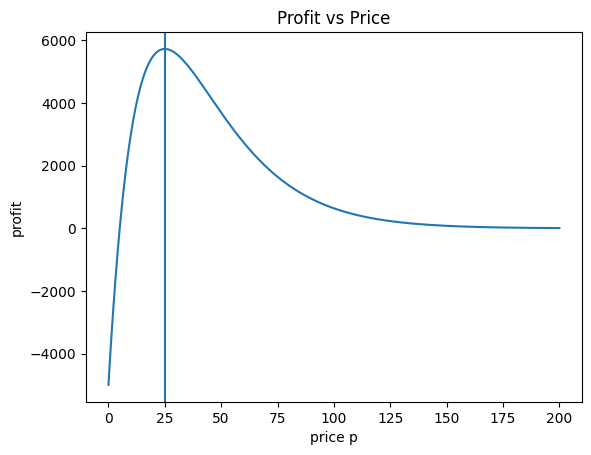

In [21]:
import matplotlib.pyplot as plt

ps = np.linspace(0, 200, 201)
profits = [(p - unit_cost) * demand(p) for p in ps]

plt.figure()
plt.plot(ps, profits)
plt.axvline(p_star)
plt.xlabel("price p")
plt.ylabel("profit")
plt.title("Profit vs Price")
plt.show()


## 6. Tổng kết: kỹ thuật cổ điển nằm ở đâu trong ML/AI pipeline?

- Regression: baseline + interpretability + sanity check
- Hypothesis testing: kiểm chứng claim + hiểu dữ liệu + A/B style reasoning
- Optimization: ra quyết định dưới ràng buộc, thường đứng sau ML


# Bài tập về nhà
1) Trả lời tất cả câu hỏi bắt buộc trong notebook (ngắn gọn, 3–6 dòng/câu).
2) Thay bài toán LP bằng một kịch bản liên quan đến project của nhóm bạn (tối thiểu 2 ràng buộc).
3) Với dữ liệu đồ án:
   - đề xuất 1 baseline hồi quy hoặc kiểm định giả thuyết phù hợp
   - mô tả rủi ro p-hacking hoặc leakage có thể gặp


## 0. Setup & Reproducibility
Cố định seed, in versions, tạo thư mục outputs.

In [22]:
# 0) Setup
import json, os, sys, platform
from datetime import datetime

import numpy as np
import pandas as pd
import sklearn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("python:", sys.version)
print("platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1


## 1. Dataset (dữ liệu mẫu cho regression + hypothesis testing)


Nghiên cứu sử dụng dataset **[Retail Store Inventory and Demand Forecasting](https://www.kaggle.com/datasets/atomicd/retail-store-inventory-and-demand-forecasting/data)**
được công bố trên Kaggle.

- Target: `Demand` – đại diện cho nhu cầu (demand), là biến liên tục, phù hợp với bài toán regression và demand forecasting.
- Feature: bao gồm các yếu tố liên quan đến tồn kho, giá bán và thời gian (`inventory level`, `price`, `date`), được chuẩn hóa để phục vụ huấn luyện mô hình học máy.

Dataset này phù hợp cho mục tiêu dự báo nhu cầu và làm đầu vào cho bài toán đề xuất mức tồn kho an toàn (safety stock).





In [25]:
!pip install -q kagglehub[pandas-datasets]

In [27]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "sales_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "atomicd/retail-store-inventory-and-demand-forecasting",
    file_path,
)

df.head()


/tmp/ipython-input-1143135028.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'retail-store-inventory-and-demand-forecasting' dataset.


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [28]:
print("shape:", df.shape)
df.describe().T.head(12)

shape: (76000, 16)


,count,mean,std,min,25%,50%,75%,max
Inventory Level,76000.0,301.062842,226.510161,0.00,136.0000,227.0,408.0000,2267.00
Units Sold,76000.0,88.827316,43.994525,0.00,58.0000,84.0,114.0000,426.00
Units Ordered,76000.0,89.090645,162.404627,0.00,0.0000,0.0,121.0000,1616.00
Price,76000.0,67.726028,39.377899,4.74,31.9975,64.5,95.8300,228.03
Discount,76000.0,9.087039,7.475781,0.00,5.0000,10.0,10.0000,25.00
Promotion,76000.0,0.328947,0.469834,0.00,0.0000,0.0,1.0000,1.00
Competitor Pricing,76000.0,69.454029,40.943818,4.29,32.6200,65.7,97.9325,261.22
Epidemic,76000.0,0.200000,0.400003,0.00,0.0000,0.0,0.0000,1.00
Demand,76000.0,104.317158,46.964801,4.00,71.0000,100.0,133.0000,430.00


## 2. Hồi quy tuyến tính (Linear Regression) như baseline + interpretability
### **Câu hỏi**
1) Với dữ liệu của nhóm bạn, hồi quy tuyến tính có thể là baseline không? Vì sao?

Hồi quy tuyến tính (Ordinary Least Squares – OLS) phù hợp làm baseline cho dataset Retail Inventory & Demand.

- OLS cung cấp mối quan hệ tuyến tính trực tiếp giữa feature (inventory, price, time) và demand.
- sales_quantity là biến liên tục → đúng bản chất bài toán regression.
- Baseline phổ biến trong nhiều nghiên cứu demand forecasting


2) Nếu feature có quan hệ phi tuyến, dấu hiệu nào cho thấy OLS không phù hợp?
- Residual không phân bố ngẫu nhiên
- Quan hệ giữa feature–target không tuyến tính.
- Feature engineering (interaction terms, polynomial features) tuyến tính không cải thiện

Hướng xử lý: sử dụng các mô hình Tree-based, LSTM, hoặc hybrid

In [32]:
df["Date"] = pd.to_datetime(df["Date"])

df_agg = (
    df.groupby(["Date", "Store ID", "Product ID"], as_index=False)
      .agg({
          "Demand": "sum",
          "Units Sold": "sum",
          "Units Ordered": "sum",
          "Inventory Level": "mean",
          "Price": "mean",
          "Discount": "mean",
          "Competitor Pricing": "mean",
          "Promotion": "max",
          "Epidemic": "max",
          "Category": "first",
          "Region": "first",
          "Seasonality": "first",
          "Weather Condition": "first"
      })
)


### 2.1 Train/Test split (để tránh đánh giá ảo)

1. Đảm bảo dữ liệu được xếp theo thứ tự thời gian tăng dần
2. Lấy 80% dữ liệu đầu làm train, 20% dữ liệu cuối làm test
3. Giữ nguyên trật tự thời gian, ko random

In [38]:
df = df.sort_values("Date")
df = df.rename(columns={"Demand": "y"})

split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df.drop(columns=["y"])
y_train = train_df["y"]

X_test  = test_df.drop(columns=["y"])
y_test  = test_df["y"]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(60800, 15) (60800,)
(15200, 15) (15200,)


### 2.2 Linear regression bằng scikit-learn

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

{"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


TypeError: float() argument must be a string or a real number, not 'Timestamp'